# AuNRs DA figure 3

In [19]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [39]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    dEres_IG = Eres_ito - Eres_glass
    return dEres_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.97
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG = calc_dif(idx, ito_data, glass_data)
        if dEres_IG.shape == (1,): 
            dEres_IG_list.append(dEres_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    C = dEres_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    return target_Eres

## input data

In [40]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)
print(combined_data.shape)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

(1701, 7)


In [41]:
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 75) & (exp_ito_data['length'] < 100)] 
exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 27) & (exp_ito_data['width'] < 32)] 
exp_ito_data = exp_ito_data.reset_index(drop=True)
print(exp_ito_data.shape)

(106, 11)


In [42]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']
print(X_ito.shape)

(1701, 2)
(3292, 2)


In [43]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5, 10]
}

## Glass to ITO

In [44]:
maew1_array = np.array([])
mael1_array = np.array([])
yw_pred1_df = pd.DataFrame()
yl_pred1_df = pd.DataFrame()

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

gsw.fit(X_glass, yw_glass)
gsl.fit(X_glass, yl_glass)

wmodel1 = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])

lmodel1 = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel1.fit(X_glass, yw_glass)
lmodel1.fit(X_glass, yl_glass)

num_model = 15
for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_ito_data_sampled = exp_ito_data.sample(30, random_state=i)
    exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

    X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data_sampled['width']
    yl_exp_ito = exp_ito_data_sampled['length']

    # width predicting
    yw_pred1 = wmodel1.predict(X_exp_ito)
    yw_pred1_df = pd.concat([yw_pred1_df, pd.DataFrame(yw_pred1)], axis=1, sort=True)
    maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)
    maew1_array = np.append(maew1_array, maew1)

    # length predicting
    yl_pred1 = lmodel1.predict(X_exp_ito)
    yl_pred1_df = pd.concat([yl_pred1_df, pd.DataFrame(yl_pred1)], axis=1, sort=True)
    mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)
    mael1_array = np.append(mael1_array, mael1)
    
yw_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred1_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:00<00:00, 294.84it/s]


## Corr. Glass to ITO

In [45]:
ITO_nsub = 1.97
ITO_Eres = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)
X_glass['eres'] = ITO_Eres

In [46]:
maew2_array = np.array([])
mael2_array = np.array([])
yw_pred2_df = pd.DataFrame()
yl_pred2_df = pd.DataFrame()

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

gsw.fit(X_glass, yw_glass)
gsl.fit(X_glass, yl_glass)

wmodel2 = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])

lmodel2 = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel2.fit(X_glass, yw_glass)
lmodel2.fit(X_glass, yl_glass)

for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_ito_data_sampled = exp_ito_data.sample(30, random_state=i)
    exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

    X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data_sampled['width']
    yl_exp_ito = exp_ito_data_sampled['length']

    yw_pred2 = wmodel2.predict(X_exp_ito)
    yw_pred2_df = pd.concat([yw_pred2_df, pd.DataFrame(yw_pred2)], axis=1, sort=True)
    maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)
    maew2_array = np.append(maew2_array, maew2)

    yl_pred2 = lmodel2.predict(X_exp_ito)
    yl_pred2_df = pd.concat([yl_pred2_df, pd.DataFrame(yl_pred2)], axis=1, sort=True)
    mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)
    mael2_array = np.append(mael2_array, mael2)
    
yw_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred2_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:00<00:00, 294.11it/s]


## ITO to ITO

In [47]:
maew3_array = np.array([])
mael3_array = np.array([])
yw_pred3_df = pd.DataFrame()
yl_pred3_df = pd.DataFrame()

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

    # Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

gsw.fit(X_ito, yw_ito)
gsl.fit(X_ito, yl_ito)

wmodel3 = DecisionTreeRegressor(max_depth=gsw.best_params_['max_depth'],
                               min_samples_split=gsw.best_params_['min_samples_split'],
                               min_samples_leaf=gsw.best_params_['min_samples_leaf'])

lmodel3 = DecisionTreeRegressor(max_depth=gsl.best_params_['max_depth'],
                               min_samples_split=gsl.best_params_['min_samples_split'],
                               min_samples_leaf=gsl.best_params_['min_samples_leaf'])

# fitting
wmodel3.fit(X_ito, yw_ito)
lmodel3.fit(X_ito, yl_ito)

for i in tqdm(range(num_model)):
    # create the specific number of data
    exp_ito_data_sampled = exp_ito_data.sample(30, random_state=i)
    exp_ito_data_sampled = exp_ito_data_sampled.reset_index(drop=True)

    X_exp_ito = exp_ito_data_sampled.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
    yw_exp_ito = exp_ito_data_sampled['width']
    yl_exp_ito = exp_ito_data_sampled['length']

    yw_pred3 = wmodel3.predict(X_exp_ito)
    yw_pred3_df = pd.concat([yw_pred3_df, pd.DataFrame(yw_pred3)], axis=1, sort=True)
    maew3 = mean_absolute_error(yw_exp_ito, yw_pred3)
    maew3_array = np.append(maew3_array, maew3)

    yl_pred3 = lmodel3.predict(X_exp_ito)
    yl_pred3_df = pd.concat([yl_pred3_df, pd.DataFrame(yl_pred3)], axis=1, sort=True)
    mael3 = mean_absolute_error(yl_exp_ito, yl_pred3)
    mael3_array = np.append(mael3_array, mael3)
    
yw_pred3_df.columns = ['model'+str(i+1) for i in range(num_model)]
yl_pred3_df.columns = ['model'+str(i+1) for i in range(num_model)]

100%|██████████| 15/15 [00:00<00:00, 294.75it/s]


In [48]:
model_to_vis = mael1_array.argmin()
# model_to_vis = 3
yw_pred1 = yw_pred1_df['model' + str(model_to_vis+1)]
yl_pred1 = yl_pred1_df['model' + str(model_to_vis+1)]

yw_pred2 = yw_pred2_df['model' + str(model_to_vis+1)]
yl_pred2 = yl_pred2_df['model' + str(model_to_vis+1)]

yw_pred3 = yw_pred3_df['model' + str(model_to_vis+1)]
yl_pred3 = yl_pred3_df['model' + str(model_to_vis+1)]

Text(0.05, 0.95, 'Train-ITO \n Test-ITO')

C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


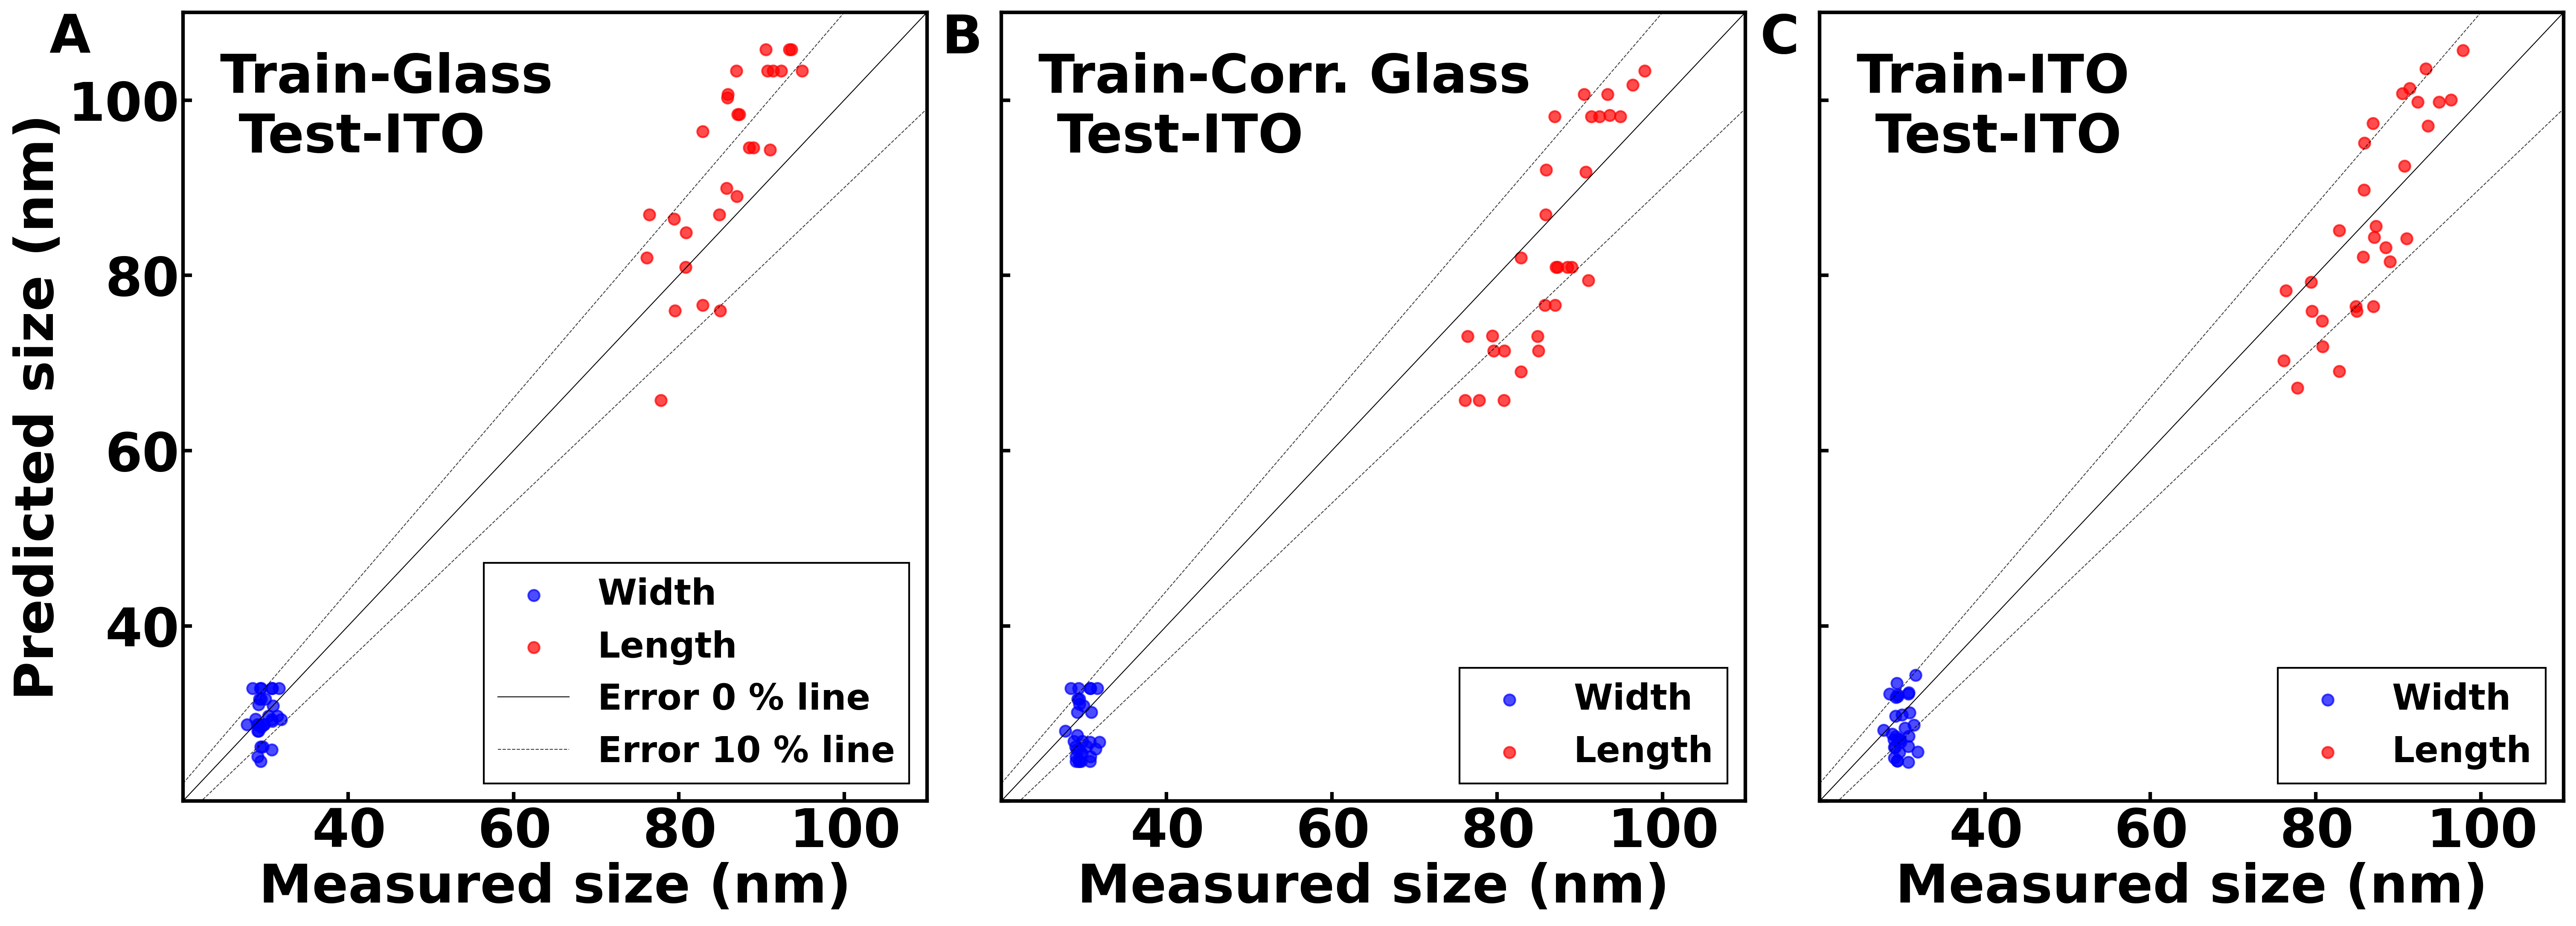

In [49]:
# Create the figure and a set of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, dpi=300) 

# First subplot
ax1.scatter(yw_exp_ito, yw_pred1, s=40, c='b', alpha=.7, label=f'Width')
ax1.scatter(yl_exp_ito, yl_pred1, s=40, c='r', alpha=.7, label=f'Length')

x = np.arange(-1, 181)
ax1.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax1.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax1.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax1.set_xticks([40, 60, 80, 100])
ax1.set_yticks([40, 60, 80, 100])
ax1.tick_params(axis='both', labelsize=30, pad=3)
ax1.set_xlabel('Measured size (nm)', fontsize=30)
ax1.set_ylabel('Predicted size (nm)', fontsize=30)
ax1.set_xlim(20, 110)
ax1.set_ylim(20, 110)
ax1.legend(loc='lower right', fontsize=20)
ax1.text(-0.18, 1, 'A', ha='left', va='top', transform=ax1.transAxes, fontsize=30)
ax1.text(0.05, 0.95, 'Train-Glass \n Test-ITO', ha='left', va='top', transform=ax1.transAxes, fontsize=30)

# Second subplot
ax2.scatter(yw_exp_ito, yw_pred2, s=40, c='b', alpha=.7, label=f'Width')
ax2.scatter(yl_exp_ito, yl_pred2, s=40, c='r', alpha=.7, label=f'Length')
ax2.plot(x, x, c='k', lw=0.5)
ax2.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
ax2.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax2.set_xticks([40, 60, 80, 100])
ax2.tick_params(labelleft=False)
ax2.tick_params(axis='both', labelsize=30, pad=3)
ax2.set_xlabel('Measured size (nm)', fontsize=30)
ax2.set_xlim(20, 110)
ax2.set_ylim(20, 110)
ax2.legend(loc='lower right', fontsize=20)
ax2.text(-0.08, 1, 'B', ha='left', va='top', transform=ax2.transAxes, fontsize=30)
ax2.text(0.05, 0.95, 'Train-Corr. Glass \n Test-ITO', ha='left', va='top', transform=ax2.transAxes, fontsize=30)

# Third subplot
ax3.scatter(yw_exp_ito, yw_pred3, s=40, c='b', alpha=.7, label=f'Width')
ax3.scatter(yl_exp_ito, yl_pred3, s=40, c='r', alpha=.7, label=f'Length')
ax3.plot(x, x, c='k', lw=0.5)
ax3.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
ax3.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax3.set_xticks([40, 60, 80, 100])
ax3.tick_params(labelleft=False)
ax3.tick_params(axis='both', labelsize=30, pad=3)
ax3.set_xlabel('Measured size (nm)', fontsize=30)
ax3.set_xlim(20, 110)
ax3.set_ylim(20, 110)
ax3.legend(loc='lower right', fontsize=20)
ax3.text(-0.08, 1, 'C', ha='left', va='top', transform=ax3.transAxes, fontsize=30)
ax3.text(0.05, 0.95, 'Train-ITO \n Test-ITO', ha='left', va='top', transform=ax3.transAxes, fontsize=30)

Text(-0.18, 1, 'C')

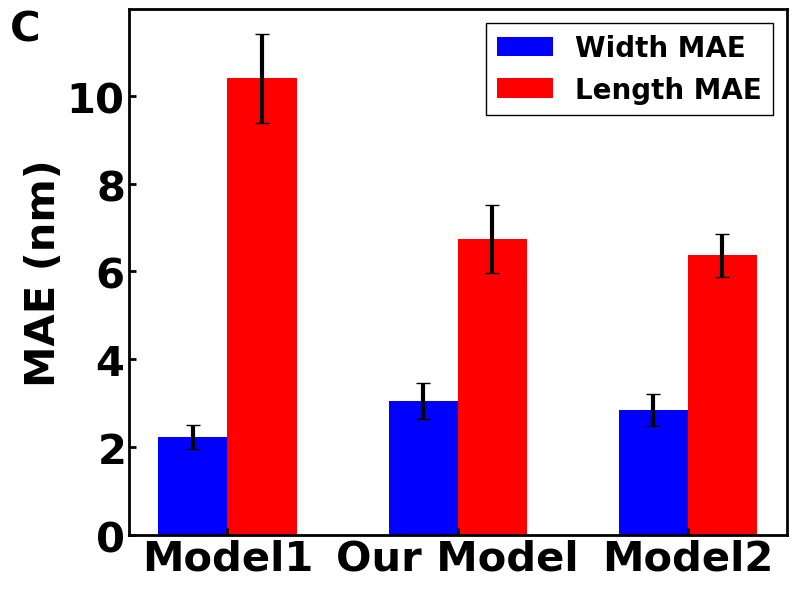

In [50]:
fig, ax3 = plt.subplots()

Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())
Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

ax3.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width MAE', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
ax3.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length MAE', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

ax3.set_xticks(index, ('Model1', 'Our Model', 'Model2'), fontsize=30)
ax3.tick_params(axis='both', labelsize=30, pad=3)
ax3.set_ylabel('MAE (nm)', fontsize=30)
ax3.legend(fontsize=20)
ax3.text(-0.18, 1, 'C', ha='left', va='top', transform=ax3.transAxes, fontsize=30)

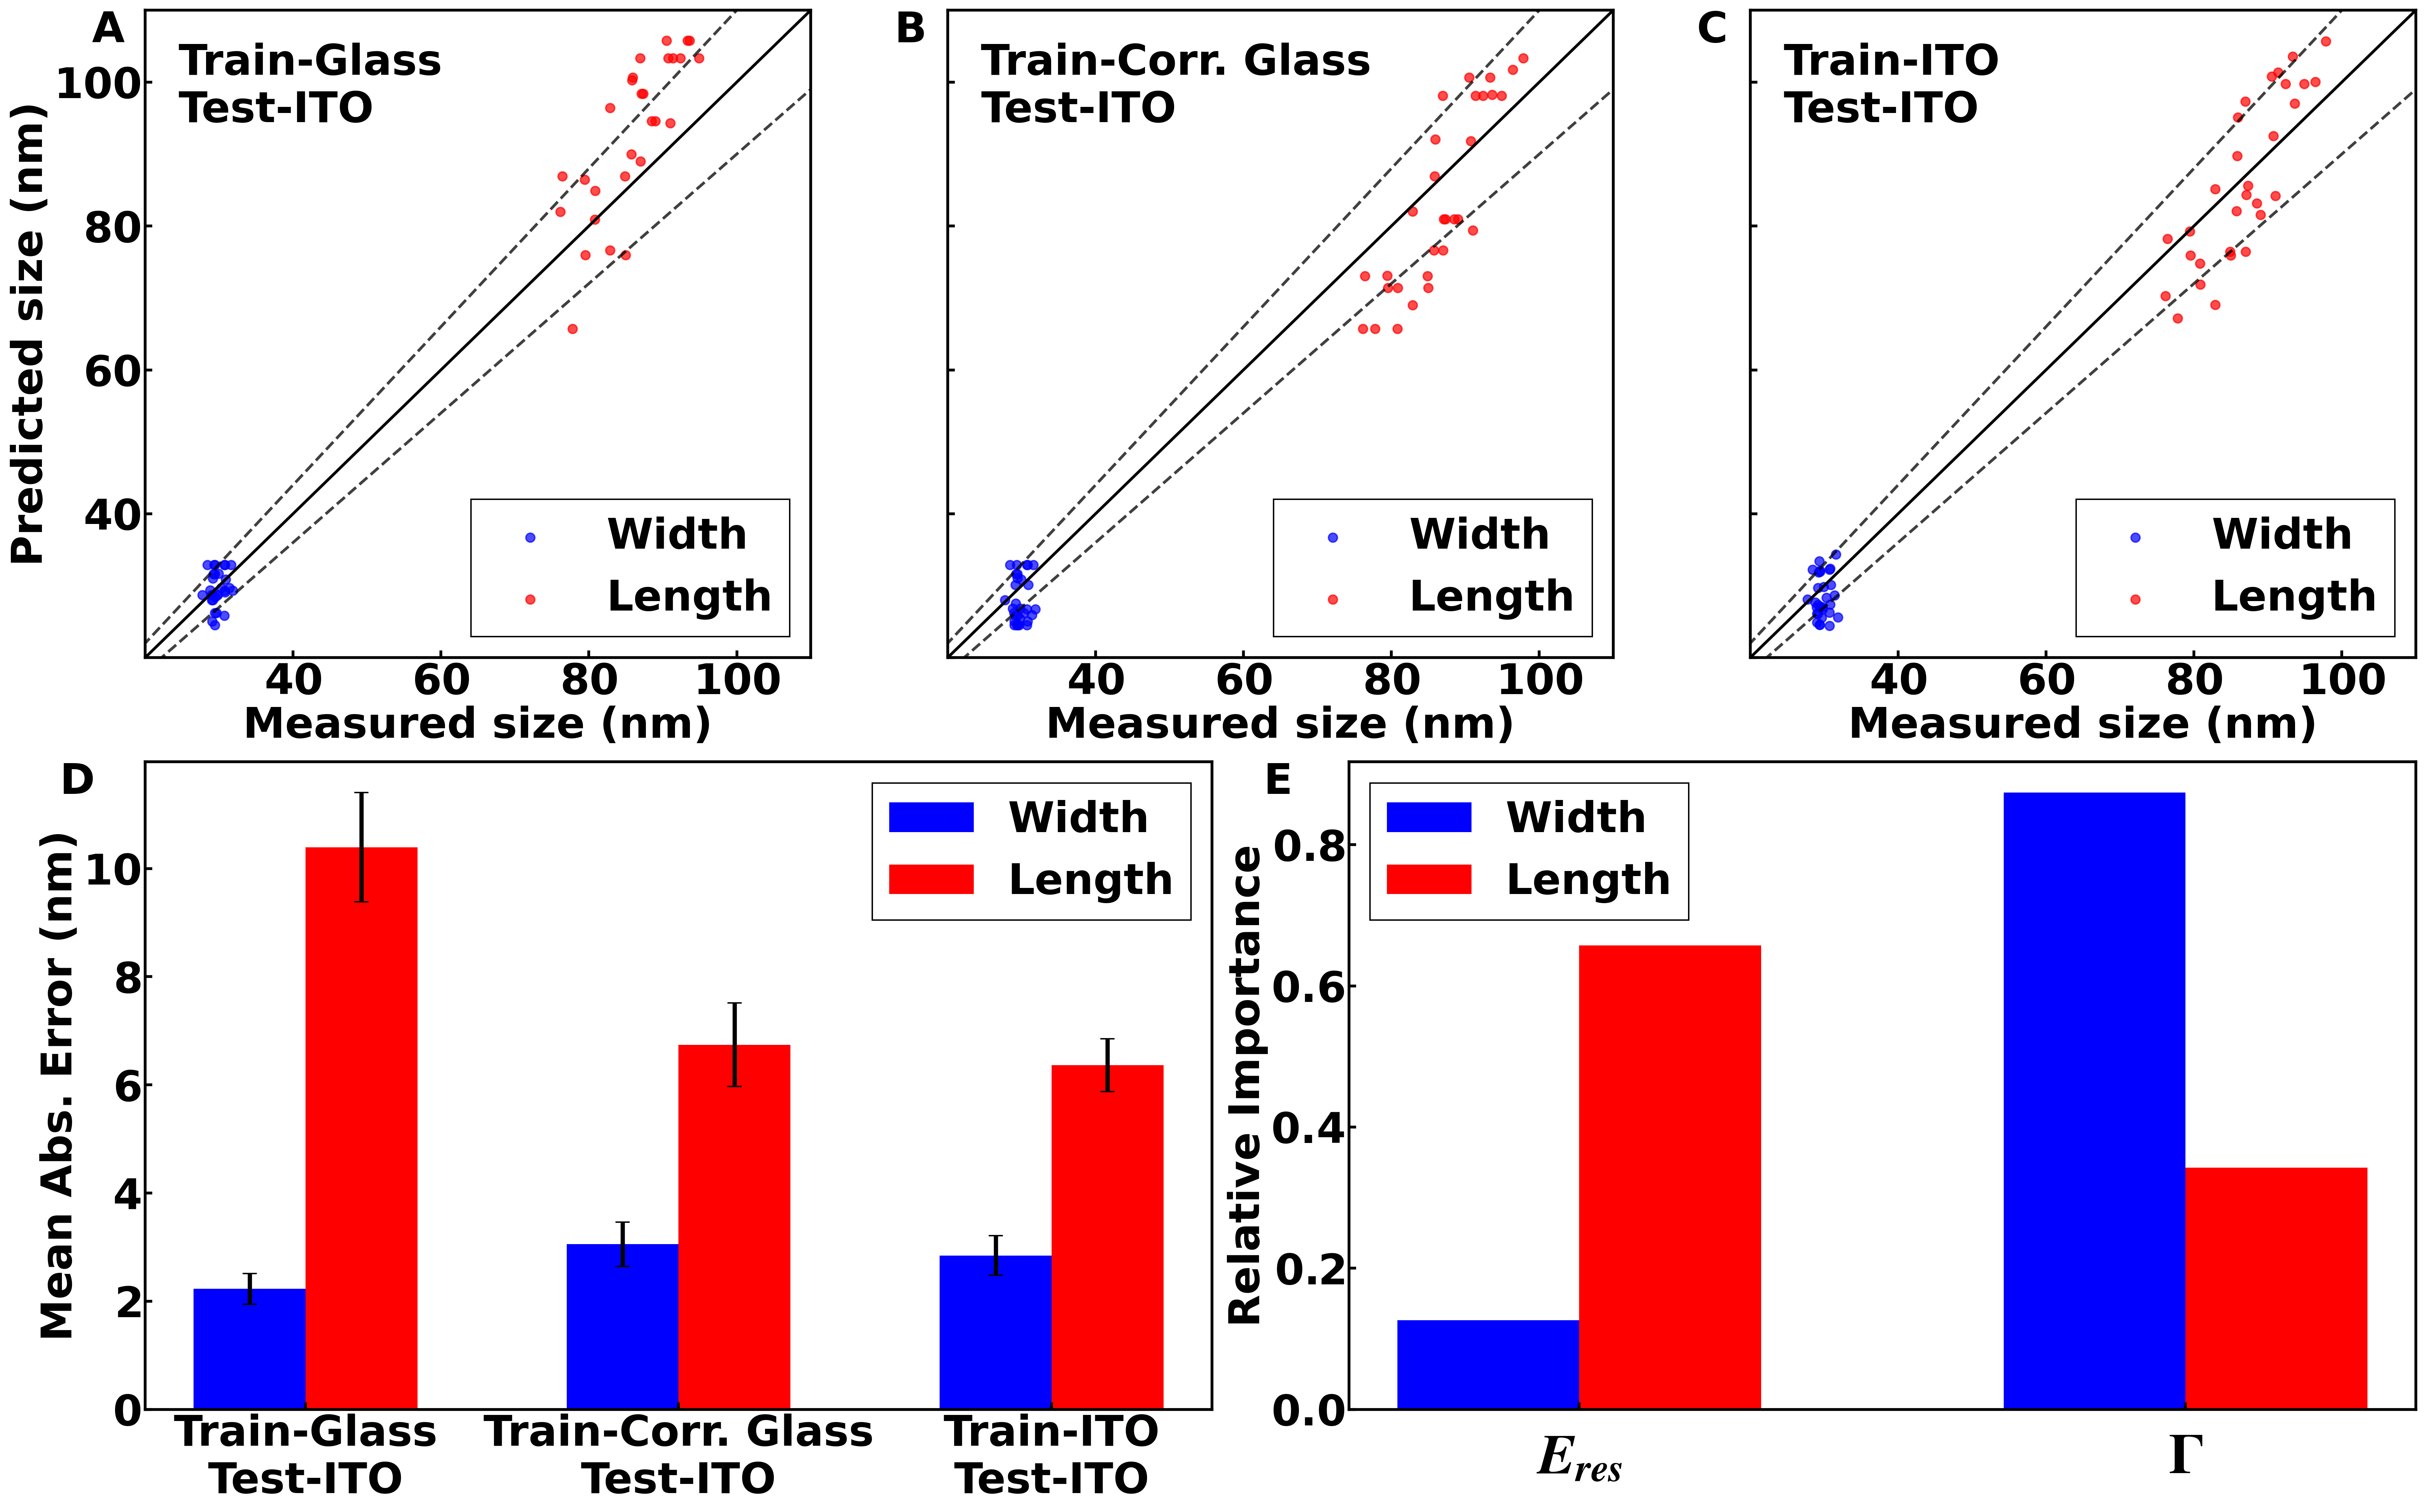

In [56]:
fig = plt.figure(figsize=(24, 15), dpi=300)

# First subplot
axA = plt.subplot2grid((2, 6), (0, 0), colspan=2)
axA.scatter(yw_exp_ito, yw_pred1, s=40, c='b', alpha=.7, label=f'Width')
axA.scatter(yl_exp_ito, yl_pred1, s=40, c='r', alpha=.7, label=f'Length')

x = np.arange(-1, 181)
axA.plot(x, x, c='k', lw=2)
axA.plot(x, 1.1*x, c='k', linestyle='--', lw=2, alpha=0.75)
axA.plot(x, 0.9*x, c='k', linestyle='--', lw=2, alpha=0.75)

axA.set_xticks([40, 60, 80, 100])
axA.set_yticks([40, 60, 80, 100])
axA.tick_params(axis='both', labelsize=30, pad=3)
axA.set_xlabel('Measured size (nm)', fontsize=30)
axA.set_ylabel('Predicted size (nm)', fontsize=30)
axA.set_xlim(20, 110)
axA.set_ylim(20, 110)
axA.legend(loc='lower right', fontsize=30)
axA.text(-0.08, 1, 'A', ha='left', va='top', transform=axA.transAxes, fontsize=30)
axA.text(0.05, 0.95, 'Train-Glass\nTest-ITO', ha='left', va='top', transform=axA.transAxes, fontsize=30)

# Second subplot
axB = plt.subplot2grid((2, 6), (0, 2), colspan=2)
axB.scatter(yw_exp_ito, yw_pred2, s=40, c='b', alpha=.7, label=f'Width')
axB.scatter(yl_exp_ito, yl_pred2, s=40, c='r', alpha=.7, label=f'Length')
axB.plot(x, x, c='k', lw=2)
axB.plot(x, 1.1*x, c='k', linestyle='--', lw=2, alpha=0.75)
axB.plot(x, 0.9*x, c='k', linestyle='--', lw=2, alpha=0.75)

axB.set_xticks([40, 60, 80, 100])
axB.tick_params(labelleft=False)
axB.tick_params(axis='both', labelsize=30, pad=3)
axB.set_xlabel('Measured size (nm)', fontsize=30)
axB.set_xlim(20, 110)
axB.set_ylim(20, 110)
axB.legend(loc='lower right', fontsize=30)
axB.text(-0.08, 1, 'B', ha='left', va='top', transform=axB.transAxes, fontsize=30)
axB.text(0.05, 0.95, 'Train-Corr. Glass\nTest-ITO', ha='left', va='top', transform=axB.transAxes, fontsize=30)

# Third subplot
axC = plt.subplot2grid((2, 6), (0, 4), colspan=2)
axC.scatter(yw_exp_ito, yw_pred3, s=40, c='b', alpha=.7, label=f'Width')
axC.scatter(yl_exp_ito, yl_pred3, s=40, c='r', alpha=.7, label=f'Length')
axC.plot(x, x, c='k', lw=2)
axC.plot(x, 1.1*x, c='k', linestyle='--', lw=2, alpha=0.75)
axC.plot(x, 0.9*x, c='k', linestyle='--', lw=2, alpha=0.75)

axC.set_xticks([40, 60, 80, 100])
axC.tick_params(labelleft=False)
axC.tick_params(axis='both', labelsize=30, pad=3)
axC.set_xlabel('Measured size (nm)', fontsize=30)
axC.set_xlim(20, 110)
axC.set_ylim(20, 110)
axC.legend(loc='lower right', fontsize=30)
axC.text(-0.08, 1, 'C', ha='left', va='top', transform=axC.transAxes, fontsize=30)
axC.text(0.05, 0.95, 'Train-ITO\nTest-ITO', ha='left', va='top', transform=axC.transAxes, fontsize=30)

axD = plt.subplot2grid((2, 6), (1, 0), colspan=3)
Width_MAE = (maew1_array.mean(), maew2_array.mean(), maew3_array.mean())
Length_MAE = (mael1_array.mean(), mael2_array.mean(), mael3_array.mean())
Width_MAE_errors = (maew1_array.std(), maew2_array.std(), maew3_array.std())
Length_MAE_errors = (mael1_array.std(), mael2_array.std(), mael3_array.std())

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

axD.bar(index - bar_width / 2, Width_MAE, bar_width, alpha=opacity, color='b', label='Width', align='center',
        yerr=Width_MAE_errors, capsize=5)  # Adding error bars for Width_MAE
axD.bar(index + bar_width / 2, Length_MAE, bar_width, alpha=opacity, color='r', label='Length', align='center',
        yerr=Length_MAE_errors, capsize=5)  # Adding error bars for Length_MAE

axD.set_xticks(index, ('Train-Glass\nTest-ITO', 'Train-Corr. Glass\nTest-ITO', 'Train-ITO\nTest-ITO'), fontsize=30)
axD.tick_params(axis='both', labelsize=30, pad=3)
axD.set_ylabel('Mean Abs. Error (nm)', fontsize=30)
axD.legend(fontsize=30)
axD.text(-0.08, 1, 'D', ha='left', va='top', transform=axD.transAxes, fontsize=30)

axE = plt.subplot2grid((2, 6), (1, 3), colspan=3)
width_importances = wmodel2.feature_importances_
length_importances = lmodel2.feature_importances_

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1.0

axE.bar(index - bar_width / 2, width_importances, bar_width, alpha=opacity, color='b', label='Width', align='center')
axE.bar(index + bar_width / 2, length_importances, bar_width, alpha=opacity, color='r', label='Length', align='center')
axE.tick_params(axis='y', labelsize=30, pad=3)
axE.tick_params(axis='x', labelsize=40, pad=15)
axE.set_xticks(index, ('$E_{res}$', '$\Gamma$'))
axE.set_ylabel('Relative Importance', fontsize=30)
axE.legend(fontsize=30)
axE.text(-0.08, 1, 'E', ha='left', va='top', transform=axE.transAxes, fontsize=30)

plt.tight_layout()
plt.savefig('AuNRs_DA_figure3.png', dpi=300)

In [52]:
print(f'{maew1_array.mean()} ± {maew1_array.std()}')
print(f'{maew2_array.mean()} ± {maew2_array.std()}')

2.2277045648129654 ± 0.2830289936645835
3.0547723941421165 ± 0.4102444558868056


In [53]:
print(f'{mael1_array.mean()} ± {mael1_array.std()}')
print(f'{mael2_array.mean()} ± {mael2_array.std()}')

10.39316995014663 ± 1.0102721635036678
6.74257639727715 ± 0.7715950131243007


In [54]:
print(f'{maew3_array.mean()} ± {maew3_array.std()}')
print(f'{mael3_array.mean()} ± {mael3_array.std()}')

2.844584310405645 ± 0.3653981916915924
6.363760373897708 ± 0.4898742684629449
